In [1]:
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from  torch.optim import Adam
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from torchvision import transforms

In [3]:
def load_mnist_data(root_path: str, download: bool = False, **train_args):
    image_augmentation = transforms.Compose([
        #transforms.Resize((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0,), std=(1,)) # mean, std across image channel
    ])

    train_dataset = MNIST(root_path, transform= image_augmentation, train=True, download=download)
    test_dataset = MNIST(root_path, transform= image_augmentation, train=False, download=download)

    train_loader = DataLoader(train_dataset, pin_memory=True ,**train_args)
    test_loader = DataLoader(test_dataset, pin_memory=True, **train_args)

    return train_loader, test_loader


In [4]:
from typing import NamedTuple

mnist_path = "./data/"

load_args = {
    "batch_size" : 128,
    "shuffle": True,
    "num_workers": 0
}

train_loader, test_loader = load_mnist_data(mnist_path,**load_args)

In [5]:
x = torch.randn( (128,1, 28, 28))

n = nn.Sequential(
    nn.Conv2d(x.shape[1], 16, kernel_size=(3,3), padding=(1,1)),
    nn.ReLU(),
    nn.Conv2d(16,16, kernel_size=(2,2), stride=(2, 2), padding=(1,1) )
    #nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), padding=(1,1)),
    # nn.ReLU(),
    # nn.Conv2d(16, 32, kernel_size=(3,3), padding=(1,1)),
    # nn.ReLU(),
    # nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1)),

    # nn.Conv2d(32, 64, kernel_size=(3,3), padding=(1,1)),
    # nn.ReLU(),
    # nn.Conv2d(64,64, kernel_size=(3,3), padding=(1,1)),
    # nn.ReLU(),

    # nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), padding=(1,1)),
    # nn.AvgPool2d(kernel_size=(4,4)),
    # nn.Conv2d(64, 50, kernel_size=(1,1)),
    # nn.Conv2d(50,10, kernel_size=(1,1)),
    # nn.Flatten(1)

    # nn.Conv2d(32, 50, kernel_size=(7, 7)),
    # nn.ReLU(),
    # nn.Conv2d(50, 10, kernel_size=(1,1)),
    # nn.ReLU(),
    # nn.Flatten(1),
    # nn.Linear(7*7*32, 50),
    # nn.ReLU(),
    # nn.Linear(50,10)

    # nn.Conv2d(32, 7 * 7, kernel_size=(1,1), stride=(1,1)),
    # nn.ReLU(),
    # nn.Conv2d(7*7, 15, kernel_size=(1,1)),
    # nn.ReLU(),
    # nn.AvgPool2d(kernel_size=(7,7)),
    # nn.Flatten(1)
)

print(7*7*32)

output = n.forward(x)

#output = output.reshape( *output.shape[:2] )
output.shape


1568


torch.Size([128, 16, 15, 15])

In [6]:
# simulate mnist data
x = torch.randn((10,3,28,28))
print(x.shape)

# flatten last two dimension
fl = nn.Flatten(2,3)

print(fl(x).shape)

# manual step
new_shape = *x.shape[:2], x.shape[2] * x.shape[3]
print( new_shape )


torch.Size([10, 3, 28, 28])
torch.Size([10, 3, 784])
(10, 3, 784)


In [7]:
class DigitClassifier(nn.Module):
    def __init__(self, inputs : int, hidden: int, outputs: int, device="cuda"):
        super(DigitClassifier, self).__init__()

        self.hidden = 50
        self.net = nn.Sequential(
            # try conv instead of max pooling
            nn.Conv2d(1, 16, kernel_size=(3,3), padding=(1,1) ),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(2,2), stride=(2,2)),
            #nn.MaxPool2d(kernel_size=(2,2), stride = (2,2) ),

            nn.Conv2d(16, 64, kernel_size=(3,3), padding=(1,1) ),
            nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=(2,2), stride=(2,2)),
            #nn.MaxPool2d(kernel_size=(2,2), stride = (2,2) ),

            nn.Conv2d(64, 128, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(2,2), padding=(1,1), stride=(2,2)),
            #nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), padding=(1,1)),

            # convolution instead of fully connected layers
            # less no. of parameters
            #https://www.youtube.com/clip/Ugkxkwv47T4M8tWVCQKkHkK8ENB7472f5ZKV
            nn.Conv2d(128, self.hidden, kernel_size=(4,4)),
            #nn.AvgPool2d(kernel_size=(4,4)),
            #nn.Conv2d(128, self.hidden, kernel_size=(1,1)),
            nn.ReLU(),
            nn.Conv2d(self.hidden, outputs, kernel_size=(1,1)),
            nn.ReLU(),
            nn.Flatten(1)

            #4*4*128*50 parameters when used fully connected layer
            # nn.Flatten(1),
            # nn.Linear(4*4*128, self.hidden),
            # nn.ReLU(),
            # nn.Linear(self.hidden, outputs)

        ).to(device)
            
    def forward(self, x: torch.Tensor):
        return self.net.forward(x)

Training len:  469


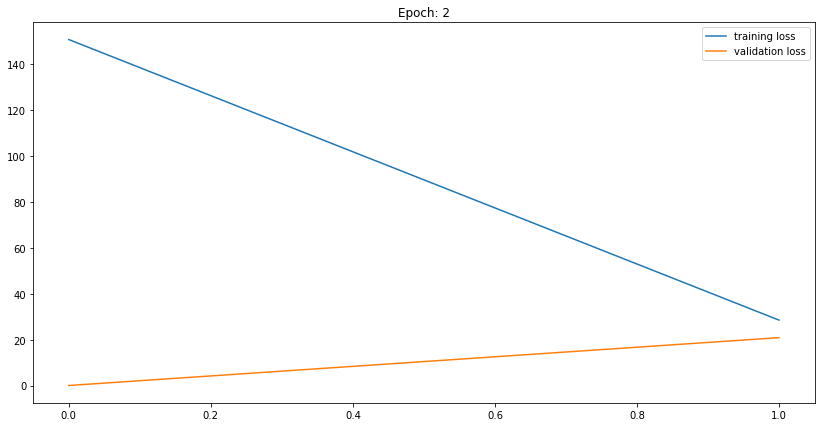

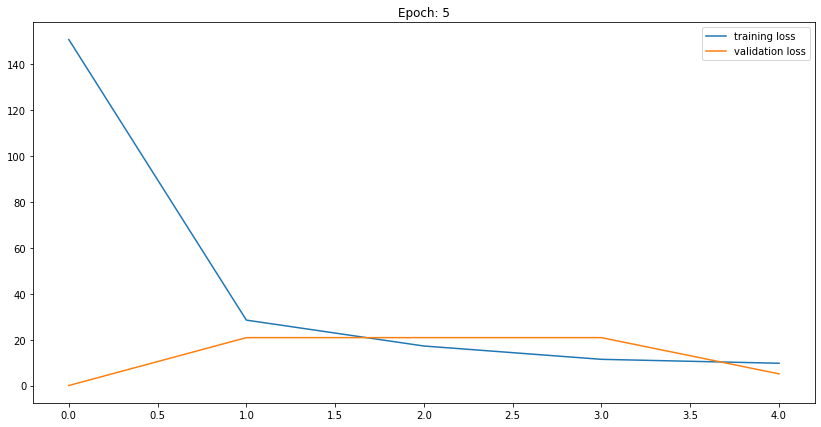

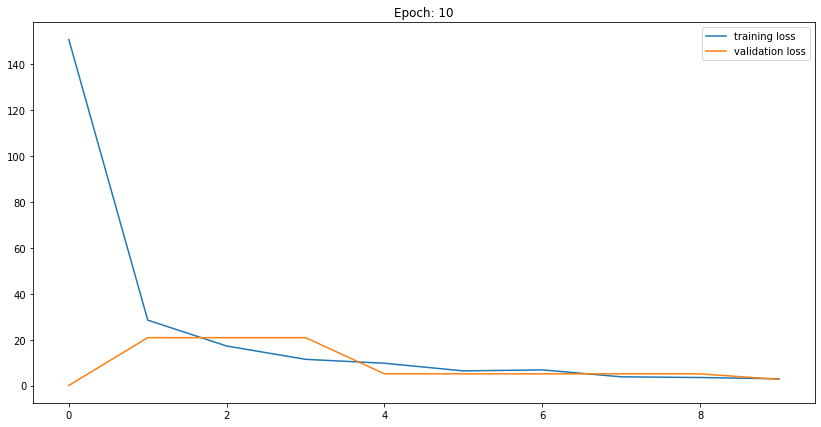

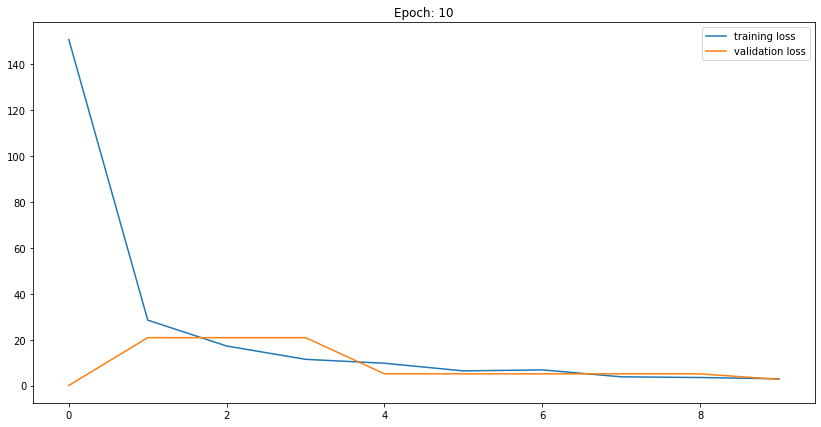

In [8]:
from torch.nn import CrossEntropyLoss

from typing import List

loss_criteria = CrossEntropyLoss()

classifier = DigitClassifier(inputs=28*28,hidden= 128, outputs=10,device="cuda")

parameters = classifier.parameters()

optimizer= Adam(parameters, lr=0.001)

def evaluation(model: nn.Module, data_loader: DataLoader, device:str="cuda"):
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for (samples, labels) in data_loader:
            x = samples.to(device)
            y = labels.to(device)

            new_shape = *x.shape[:2], x.shape[2] * x.shape[3]

            #x = x.reshape(new_shape)

            result = model.forward(x)#.squeeze(dim=1)

            loss = loss_criteria(result, y)

            total_loss += loss.item() * len(samples)

    return total_loss/len(data_loader)


def train(model: nn.Module, data_loader: DataLoader,device:str = "cuda"):
    total_loss = 0.0
    for (samples, labels) in data_loader:
        x = samples.to(device)
        y = labels.to(device)

        new_shape = *x.shape[:2], x.shape[2] * x.shape[3]

        #x = x.reshape(new_shape)

        result = model.forward(x)#.squeeze(dim=1)

        #print("After result: ", x.shape, y.shape)

        loss = loss_criteria(result, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(samples)

    return total_loss/len(data_loader)

def plot_losses(train_losses: List[float], eval_losses: List[float], epoch: int):
    plt.figure(figsize=(14,7))

    plt.title(f"Epoch: {epoch}")

    plt.plot(np.arange(len(train_losses)), train_losses)
    plt.plot(np.arange(len(eval_losses)), eval_losses)

    plt.legend(['training loss', 'validation loss', ], loc='upper right')
    plt.show()

print( f"Training len: ", len(train_loader))

train_losses = []
eval_losses = []

train_loss = 0
eval_loss = 0

epoch_count = 10

for epoch in range(1, epoch_count + 1):
    train_loss = train(classifier, test_loader,"cuda")
    train_losses.append(train_loss)

    if epoch == 2 or epoch % 5 == 0:
        eval_loss = evaluation(classifier, test_loader,"cuda")
        eval_losses.append(eval_loss)
        plot_losses(train_losses, eval_losses, epoch)
        continue
    
    eval_losses.append(eval_loss)

plot_losses(train_losses, eval_losses,epoch_count)

